# Complete experiment to try to estimate the profits from a customer, in the next 10 days, given different offer choices to be shown.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_spent_10_days.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.data.profit_10_days_dataset as p10
import src.visualization.visualize as vis

## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [2]:
# Get the data
X_train, X_test, y_train, y_test, encoder, view_cols, profit_cols =\
p10.get_profit_10_days_data(fill_null=True, 
                        target=['viewed', 'profit_10_days'], drop_offer_id=False)

In [3]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(25319, 127)
(25319, 2)


,offer_id,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,channel_mobile_success_ratio,difficulty_viewcol,duration_viewcol,reward_t_viewcol,channel_web_viewcol,channel_mobile_viewcol,channel_email_viewcol,channel_social_viewcol,offer_id_viewcol,offer_type_viewcol
0,5a8bc65990b245e5a138643cd4eb9837,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,...,0.0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,5a8bc65990b245e5a138643cd4eb9837,informational
5,f19421c1d4aa40978ebb69ca19b0e20d,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,...,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,3f207df678b143eea3cee63160fa8bed,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,1.0,0.0,3f207df678b143eea3cee63160fa8bed,informational
8,2298d6c36e964ae4a3e7e9706d1fb8c2,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,...,0.0,7.0,7.0,3.0,1.0,1.0,1.0,1.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount
12,fafdcd668e3743c1bb461111dcafc2a4,59.0,F,90000.0,0,16864,10.0,10.0,discount,2.0,...,0.0,10.0,10.0,2.0,1.0,1.0,1.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,discount


In [4]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(12778, 127)
(12778, 2)


,offer_id,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,channel_mobile_success_ratio,difficulty_viewcol,duration_viewcol,reward_t_viewcol,channel_web_viewcol,channel_mobile_viewcol,channel_email_viewcol,channel_social_viewcol,offer_id_viewcol,offer_type_viewcol
2,no_offer,33.0,M,72000.0,0,17277,0.0,0.0,no_offer,0.0,...,0.000000,5.0,5.0,5.0,1.0,1.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
10,0b1e1539f2cc45b7b9fa7c272da2e1d7,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,...,0.333332,20.0,10.0,5.0,1.0,0.0,1.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
15,4d5c57ea9a6940dd891ad53e9dbe8da0,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,...,0.666664,10.0,5.0,10.0,1.0,1.0,1.0,1.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo
19,5a8bc65990b245e5a138643cd4eb9837,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,...,0.999995,0.0,3.0,0.0,0.0,1.0,1.0,1.0,5a8bc65990b245e5a138643cd4eb9837,informational
24,fafdcd668e3743c1bb461111dcafc2a4,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,...,0.333332,10.0,10.0,2.0,1.0,1.0,1.0,1.0,fafdcd668e3743c1bb461111dcafc2a4,discount


## 2. Create the model <a id='model'/>
[Top](#top)

In [5]:
model = p10.ProfitsPredictor(encoder=encoder, view_cols=view_cols, profit_cols=profit_cols)

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

Due to the small amount of time instances, there will be no validation set, or grid search. Instead one model will be implemented and tested (a test set is separated).

In [6]:
%time model.fit(X_train, y_train)

CPU times: user 42.7 s, sys: 165 ms, total: 42.9 s
Wall time: 42.4 s


ProfitsPredictor(encoder=BasicEncoderProfits(custom_features=None),
         profit_cols=['difficulty', 'duration', 'reward_t', 'channel_web', 'channel_mobile', 'channel_email', 'channel_social', 'offer_id', 'offer_type'],
         view_cols=['difficulty_viewcol', 'duration_viewcol', 'reward_t_viewcol', 'channel_web_viewcol', 'channel_mobile_viewcol', 'channel_email_viewcol', 'channel_social_viewcol', 'offer_id_viewcol', 'offer_type_viewcol'])

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

In [7]:
from xgboost import plot_importance

In [8]:
n_feats = 20

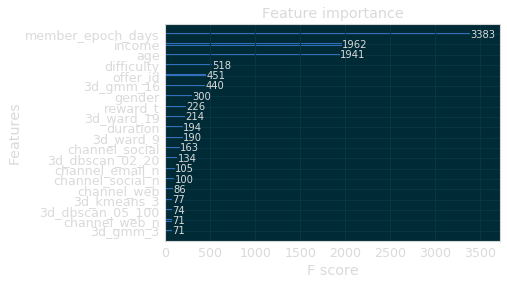

In [9]:
plot_importance(model.views_model.named_steps['estimator'], max_num_features=n_feats)

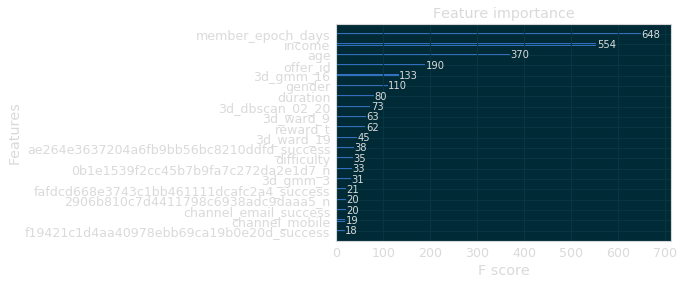

In [10]:
plot_importance(model.profits_model.named_steps['estimator'], max_num_features=n_feats)

In [11]:
y_train_pred = model.predict(X_train)
print('Training error (RMSE) = {}'.format(np.sqrt(mse(y_train['profit_10_days'], y_train_pred))))

Training error (RMSE) = 52.48788965297152


## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [12]:
y_test_pred = model.predict(X_test)
print('Test error (RMSE) = {}'.format(np.sqrt(mse(y_test['profit_10_days'], y_test_pred))))

Test error (RMSE) = 67.39887382624389


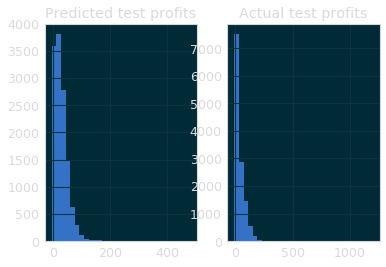

In [13]:
n_bins = 30
plt.subplot(1,2,1)
_ = plt.hist(y_test_pred, bins=n_bins)
plt.title('Predicted test profits')
plt.subplot(1,2,2)
y_test['profit_10_days'].hist(bins=n_bins)
_ = plt.title('Actual test profits')

### Pseudo AB test

Ideally, to further test the model, it would be a good idea to perform an AB test. In a perfect situation we would be able to collect data from reality. In a less idealized world we would have access to a simlator, to which we can input offers. In the actual case, the only thing available is data from a simulator that was generated in the past, without any possibility of generating new data with our desired specifications. In any case, it is possible to perform what I call a "pseudo AB test".

The idea is to predict which are the best offers for each customer, then look for cases in the test set where, by chance, exactly those offers were sent. That will be the sample "with the new predictor". A random sample from the test set (of the same size as the one obtained before), will be the sample "without the predictor" (the samples may overlap, but that is not important; the important thing is that the second sample comes from the "old offer-sending procedure" distribution).

That method is far less than ideal. In particular the sample size is determined by chance and cannot be controlled. Despite that, its significance can be assessed.

In [14]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time _, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

portfolio

Basic preprocessing
CPU times: user 1.64 s, sys: 32 ms, total: 1.67 s
Wall time: 1.67 s


,difficulty,duration,id,offer_type,reward,channel_social,channel_mobile,channel_web,channel_email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


In [52]:
selected_offers, predicted_full = p10.choose_offer(model, X_test, portfolio)
selected_offers.head()

0    fafdcd668e3743c1bb461111dcafc2a4
1    fafdcd668e3743c1bb461111dcafc2a4
2    fafdcd668e3743c1bb461111dcafc2a4
3    fafdcd668e3743c1bb461111dcafc2a4
4                            no_offer
dtype: object

In [76]:
num_samples = (X_test.offer_id == selected_offers.values).sum()
print('The old procedure sent the model\'s preferred offer in {0:.1f}% of the cases'.format(
    100*(X_test.offer_id == selected_offers.values).mean()))
print('There are {} samples of the selected offers of the new model.'.format(num_samples))

# Old model
np.random.seed(2018)
old_res = y_test.loc[np.random.choice(y_test.index, num_samples, replace=False), :].sum()
print('\n' + '-'*100)
print('Total views for the old model: {} ({}%)'.format(old_res['viewed'], 100*old_res['viewed']/num_samples))
print('Total profit for the old model: {}'.format(old_res['profit_10_days']))

# New model
new_res = y_test[(X_test.offer_id == selected_offers.values)].sum()
print('-'*100)
print('Total views for the new model: {} ({}%)'.format(new_res['viewed'], 100*new_res['viewed']/num_samples))
print('Total profit for the new model: {}'.format(new_res['profit_10_days']))
print('-'*100)



The old procedure sent the model's preferred offer in 10.3% of the cases
There are 1311 samples of the selected offers of the new model.

----------------------------------------------------------------------------------------------------
Total views for the old model: 972.0 (74.14187643020595%)
Total profit for the old model: 55700.85999999998
----------------------------------------------------------------------------------------------------
Total views for the new model: 1058.0 (80.70175438596492%)
Total profit for the new model: 62305.91000000004
----------------------------------------------------------------------------------------------------
